## Majority Voting based k-Nearest Neighbors

In [1]:
from typing import List, NamedTuple
from collections import Counter
import math

Vector = List[float]

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def subtract(v: Vector, w: Vector) -> Vector:
    """Subtracts corresponding elements"""
    assert len(v) == len(w), "vectors must be the same length"

    return [v_i - w_i for v_i, w_i in zip(v, w)]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v: Vector) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    
    num_winners = len([count
                      for count in vote_counts.values() 
                      if count == winner_count])
    if num_winners == 1:
        return winner
    else:
        return majority_vote(labels[:-1])

def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:
    by_distance = sorted(labeled_points, 
                         key=lambda lp: distance(lp.point, new_point))
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    
    return majority_vote(k_nearest_labels)

## k-NN on Iris dataset

### Download the Iris Dataset from UCI Repository

In [2]:
import requests
data = requests.get(
  "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
)

with open('iris.data', 'w') as f:
    f.write(data.text)

### Data Preparation

In [3]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    label = row[-1].split("-")[-1]
    
    return LabeledPoint(measurements, label)

with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader if len(row) > 0]
    
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

### Data Exploration

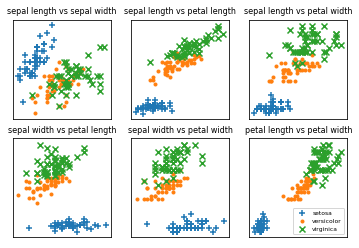

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline 

metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
        
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)
            
ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.savefig('pairplot.png')

In [5]:
import random
from typing import TypeVar, List, Tuple
X = TypeVar('X')  # generic type to represent a data point

def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.


random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)

confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0
for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    
    if predicted == actual:
        num_correct += 1
        
    confusion_matrix[(predicted, actual)] += 1
    
pct_correct = num_correct / len(iris_test)

print(f"Accuracy: {pct_correct:.4f}\n")

print("Confusion Matrix")
print("="*50)
for cls, cnt in confusion_matrix.items():
    print(f"Actual[{cls[0]:10s}] - Predicted:[{cls[1]:10s}] || {cnt}")
print("="*50)

Accuracy: 0.9778

Confusion Matrix
Actual[setosa    ] - Predicted:[setosa    ] || 13
Actual[versicolor] - Predicted:[versicolor] || 15
Actual[virginica ] - Predicted:[virginica ] || 16
Actual[virginica ] - Predicted:[versicolor] || 1


## The Curse of Dimensionality

In [6]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distance(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim)) 
            for _ in range(num_pairs)]

In [7]:
import tqdm
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distance(dim, 10000)
    avg_distances.append(sum(distances) / 10000)
    min_distances.append(min(distances))

Curse of Dimensionality: 100%|██████████| 100/100 [00:29<00:00,  1.77it/s]


Text(0.5, 0, '# of dimensions')

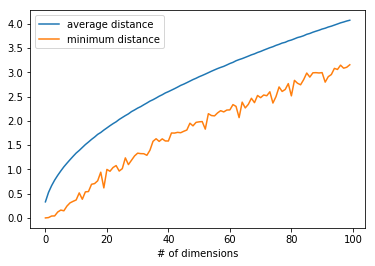

In [8]:
plt.plot(avg_distances, label='average distance')
plt.plot(min_distances, label='minimum distance')
plt.legend()
plt.xlabel('# of dimensions')

Text(0.5, 1.0, 'Minimum Distance / Average Distance')

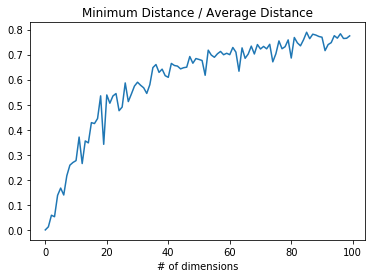

In [9]:
min_avg_ratio = [min_dist/avg_dist 
                for min_dist, avg_dist in zip(min_distances, avg_distances)]

plt.plot(min_avg_ratio)
plt.xlabel('# of dimensions')
plt.title('Minimum Distance / Average Distance')

In [10]:
import pandas as pd
iris = pd.read_csv('iris.data', 
                   names=['sepal_length', 'sepal_width', 
                          'petal_length', 'petal_width', 'species'])
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa
